# NDVI from Sentinel-2 Imagery

Using Sentinel-2 imagery, we will generate an NDVI time series for a single point located in the Kolstad Lake Waterfowl Production Area, a small nature preserve in the middle of North America. The point is 45.5°N, 95.5°W. We will use the atmospherically corrected images available from the Sentinel-2 L2A collection.

In [1]:
import pystac_client
import stackstac # !!! as of June 5, 2023, stackstac is not compatible with numpy > 1.23.5 !!!
import matplotlib.pyplot as plt

In [2]:
point_lat, point_lon = 45.5, -95.5

## Metadata
To begin, we need to generate a list of all Sentinel-2 L2A images that contain our desired location. To do that we query a repository of L2A metadata stored on S3 and accessible via an API developed by Element 84, an AWS partner. The metadata will be in STAC (Spatiotemporal Asset Catalog) format, so we’ll use the PySTAC client to interface with the Element 84 end point:

In [3]:
sentinel_search_url = "https://earth-search.aws.element84.com/v1"
sentinel_stac_client = pystac_client.Client.open(sentinel_search_url)
items = sentinel_stac_client.search(
       intersects=dict(type="Point", coordinates=(point_lon, point_lat)),
       collections=["sentinel-2-l2a"]).item_collection()
len(items)

1552

Items is a collection of python dictionaries, each containing a myriad of metadata about a single Sentinel-2LA image. In fact, each dictionary is in the order of megabytes in size, so batch processing should be considered when querying numerous points.

If you are curious, you can peek at on item:

In [4]:
items[0]

id: S2B_14TQR_20230603_0_L2A
"bbox: [-96.10656815060791, 44.99759702896828, -95.00069296675194, 46.00789822993408]"
created: 2023-06-04T02:05:48.968Z
platform: sentinel-2b
constellation: sentinel-2
instruments: ['msi']
eo:cloud_cover: 9.352396
proj:epsg: 32614
mgrs:utm_zone: 14
mgrs:latitude_band: T
mgrs:grid_square: QR


## Get the Sensor Readings

From here we will begin processing, but note we will do so lazily; that means our actions will actually just be logged in the metadata for later processing. By deferring actual processing, we can ultimately do only those computations that affect the final output we want thus minimizing the computational and network loads.

The first thing we will do is transform the collection of STAC metadata into a three dimensional array. One dimension will be time (and will be of length 1518), the two other dimensions will be latitude and longitude. The elements will be the red and near-infrared (NIR) sensor readings.

The stackstac library is designed to do precisely this. You specify a region of interest in terms of latitude and longitude and the assets you wish to extract from the imagery (in our case, red and NIR sensor readings). Given these specifications and a collection of STAC metadata, then the stackstac.stack() function will return a lazy, three dimensional xarray.Dataset (time, lat,long) where each element is a tuple of “assets” from the imagery:

In [ ]:
sentinel_stack = stackstac.stack(items, assets=["red", "nir", "scl"],
                          bounds=[point_lon-0.0005, point_lat-0.0005, point_lon+0.0005, point_lat+0.0005],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326, chunksize=(1, 1, 50, 50)).rename(
       {'x': 'lon', 'y': 'lat'}).to_dataset(dim='band')

To specify the region of interest we defined a tiny area that encompasses the point we are interested in. Note, in addition to red and NIR, we request SCL (scene classification layer) which will be useful when we do q/a later in the process. The epsg argument instructs the function to use the WGS84 latitude/longitude reference system for the output. (The actual coordinate reference system used by the data is more complex and can change between images, hence the need to reproject everything to a common system). Finally, the `gdal_env` argument allows us to manage retries implicitly. (Given the volume of packages that will have to move over the internet, package loss is inevitable.)

The return value, sentinel_stack, is an xarray.DataSet:

In [6]:
sentinel_stack

<xarray.Dataset>
Dimensions:                                  (time: 1552, lat: 12, lon: 8,
                                              band: 3)
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2017-01-03...
    id                                       (time) <U24 'S2A_15TUL_20170103_...
  * lon                                      (lon) float64 -95.5 -95.5 ... -95.5
  * lat                                      (lat) float64 45.5 45.5 ... 45.5
    s2:dark_features_percentage              (time) float64 0.4675 ... 0.01267
    mgrs:latitude_band                       <U1 'T'
    ...                                       ...
    title                                    (band) <U30 'Red (band 4) - 10m'...
    raster:bands                             (band) object None ... [{'nodata...
    common_name                              (band) object 'red' 'nir' None
    center_wavelength                        (band) object 0.665 0.842 None
    full_width_half_max                      (band) object 0.038 0.145 None
    epsg                                     int64 4326
Dimensions without coordinates: band
Data variables:
    red                                      (time, lat, lon) float64 dask.array<chunksize=(1, 12, 8), meta=np.ndarray>
    nir                                      (time, lat, lon) float64 dask.array<chunksize=(1, 12, 8), meta=np.ndarray>
    scl                                      (time, lat, lon) float64 dask.array<chunksize=(1, 12, 8), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50052812266786, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (0.00013326132348367992, 9.283105634949607e-05)

Notice the length of the time dimension corresponds exactly to the number of images we had to work with. And for each time point, we have a 12 x 8 grid. For each grid point, we will have measurements for NIR, red, and SCL.

## Calculate NDVI
Now we can proceed to, still lazily, do the actual NDVI calculations while dropping redundant metadata:

In [7]:
sentinel_stack['ndvi'] = (sentinel_stack['nir'] - sentinel_stack['red'])/\
                        (sentinel_stack['nir'] + sentinel_stack['red'])
sentinel_stack = sentinel_stack[['ndvi', 'scl']]
sentinel_stack = sentinel_stack.drop([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])
sentinel_stack

<xarray.Dataset>
Dimensions:  (time: 1552, lat: 12, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-03T17:30:23.064000 ... 2023-06-03T...
  * lon      (lon) float64 -95.5 -95.5 -95.5 -95.5 -95.5 -95.5 -95.5 -95.5
  * lat      (lat) float64 45.5 45.5 45.5 45.5 45.5 ... 45.5 45.5 45.5 45.5 45.5
Data variables:
    ndvi     (time, lat, lon) float64 dask.array<chunksize=(1, 12, 8), meta=np.ndarray>
    scl      (time, lat, lon) float64 dask.array<chunksize=(1, 12, 8), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50052812266786, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (0.00013326132348367992, 9.283105634949607e-05)

We now have NDVI for every element in our xarray.Dataset; i.e. for each of 1518 time points, we have 96 NDVI values (12 latitudes x 8 longitudes). Somewhere in that 12 x 8 grid is a singular point (45.5°N, 95.5°W) for which we wish to measure NDVI.


## Interpolate
Recall that each pixel represents the average NDVI for an entire 10m x 10m area. To get the NDVI at some exact point within a pixel, you can interpolate using the NDVI for the pixel that contains the point and some number of surrounding pixels. xarray.Dataset.interp() will do this. For simplicity we will dispense with sophisticated interpolation and simply use the “nearest” (in this case the encompassing) pixel as the interpolated value for the actual point:


In [8]:
sentinel_point = sentinel_stack.interp(lat=point_lat, lon=point_lon,
                                      method="nearest")

sentinel_point is a 1 dimensional xarray.Dataset ( across time) where each element  is a tuple (NDVI,scl):


In [9]:
sentinel_point

<xarray.Dataset>
Dimensions:  (time: 1552)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-03T17:30:23.064000 ... 2023-06-03T...
    lat      float64 45.5
    lon      float64 -95.5
Data variables:
    ndvi     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    scl      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50052812266786, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (0.00013326132348367992, 9.283105634949607e-05)

For the sake of making this demo run quickly, we can (optionally) shorten sentinel_point to 8 months:


In [13]:
# sentinel_point = sentinel_point.sel(time=slice('2022-04-01', '2022-11-01'))

In production of course you can’t just shorten your time window to speed up processing. Instead computation should be moved closer to storage; i.e. the program should be run in the same cloud as the data. Parallelization (via threading or multiple machines) is of course an obvious optimization as well.


## Do the Actual Processing
Up to this point, everything we did was lazy, only affecting metadata and task graphs. Now we'll actually load our selected subset of data.


In [15]:
sentinel_point.load() # will take minutes or tens of minutes to finish

<xarray.Dataset>
Dimensions:  (time: 1552)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-03T17:30:23.064000 ... 2023-06-03T...
    lat      float64 45.5
    lon      float64 -95.5
Data variables:
    ndvi     (time) float64 0.0133 0.01648 0.06867 ... 0.4167 0.6162 0.6936
    scl      (time) float64 11.0 11.0 11.0 11.0 5.0 5.0 ... 10.0 8.0 8.0 4.0 4.0
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50052812266786, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (0.00013326132348367992, 9.283105634949607e-05)

sentinel_point is the same Dataset as before, but the values are now actually loaded and calculated. At this point we can transform the Dataset to a simple dataframe, which will be easier to work with for the finals steps:

In [16]:
sentinel_table = sentinel_point.to_dataframe()

Here’s NDVI as a function of time:

<Axes: xlabel='time'>

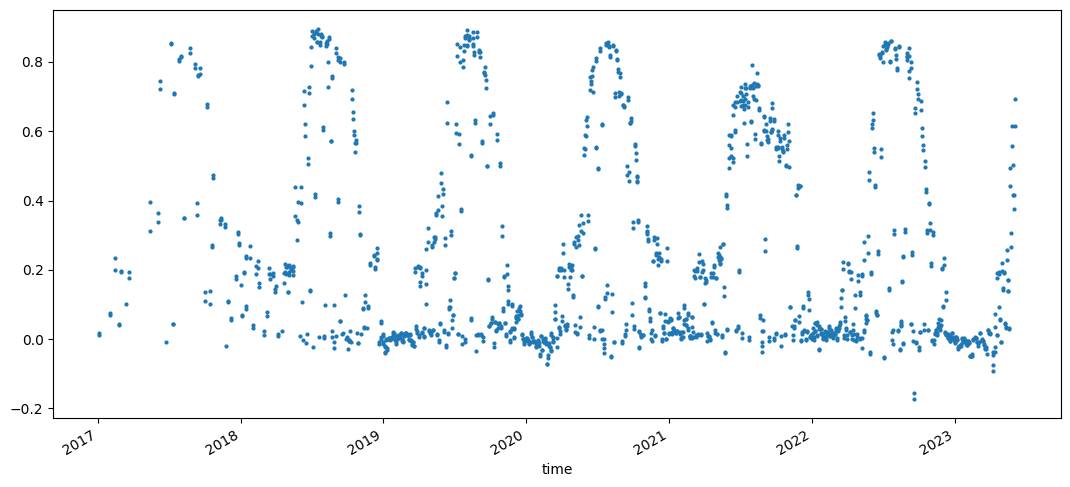

In [17]:
sentinel_table_filtered = sentinel_table[(sentinel_table['scl'] == 4) |
                                        (sentinel_table['scl'] == 5)]

plt.figure(figsize=(13, 6))

sentinel_table['ndvi'].plot(label='unfiltered', marker='o', linestyle='',markersize=2)




The plot looks good in that NDVI seems to change gradually with the season. The numerous outliers are, primarily, an artifact of cloud cover. This is where we can use the SCL data to filter out observations that were tainted by clouds. If visibility is sufficient, the Sentinel-2 sensors will classify the area we are studying as either “vegetation” (4) or “bare soil” (5). Since we know the area in question is one of those two things, then, if SCL as reported is something other than 4 or 5, then we can conclude that cloud cover is a problem and filter out that day’s NDVI value. (There is always a non-zero probability of false SCL readings, so this method is not perfect but is nonetheless highly effective.)

<Axes: xlabel='time'>

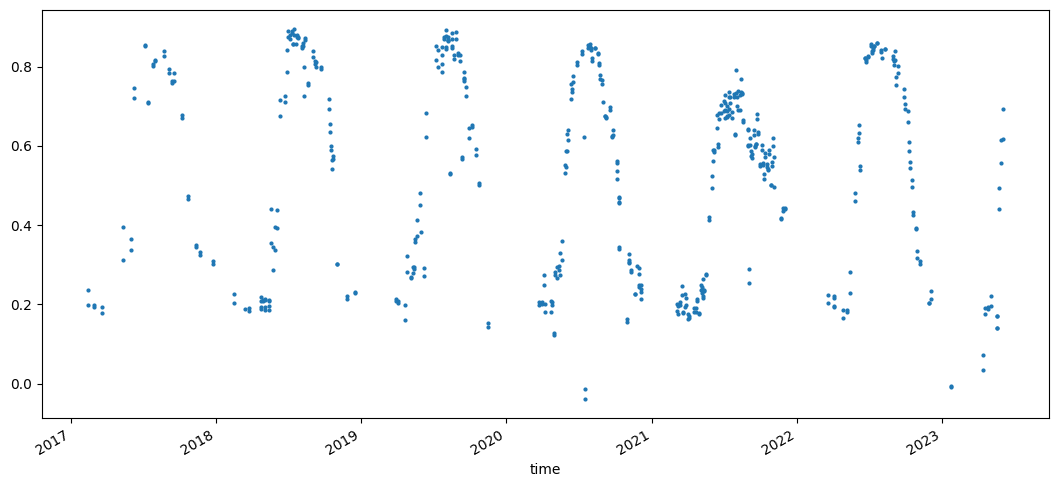

In [18]:
sentinel_table_filtered = sentinel_table[(sentinel_table['scl'] == 4) |
                                        (sentinel_table['scl'] == 5)]
plt.figure(figsize=(13, 6))
sentinel_table_filtered['ndvi'].plot(label='unfiltered', marker='o', linestyle='',markersize=2)


Now we have a NDVI time series! From here any of various interpolation/smoothing strategies can be used to estimate values for dates between observations and to remove remaining outliers.


## Conclusion

See also:
- [NDVI from First Principles](#)
- The original version of tis tutorial can be found [here](#)

# Environment
Note: At the time of publication, I had to use numpy 1.23.5, because StacStack issue [194](https://github.com/gjoseph92/stackstac/issues/194)

In [ ]:
import pkg_resources

for package in pkg_resources.working_set:
    print(package)
